# Ray tracing calculations on Jeff's data

If you are reading this before `sw-test.ipynb`, you might want to to start with that one. It is a bit simpler, conceptually speaking, and the calculations are faster. This one is closer to what a production code would be.

The purpose is to compute ray tracing equation solutions for Poincaré waves travelling on one of Jeff's vortices.

## The math

### Ray tracing equations

*A good reference is Bühler (2014, §4.4).*

Recall the local or **absolute frequency**
$$\omega_{abs} = \omega_{int} + \boldsymbol{k\cdot U}, \quad\text{where}\quad \omega_{int} = \sqrt{f^2 + gH(\boldsymbol r)\kappa^2}$$
is the **intrinsic frequency**, and where $\kappa = |\boldsymbol k| = \sqrt{k_x^2 + k_y^2}$.
The absolute frequency does not change over the course of the simulation.


The **positions** are solutions of
$$\frac{d \boldsymbol r}{dt} = \boldsymbol{\nabla}_{\boldsymbol k}\omega_{abs} = \boldsymbol c_{g} + \boldsymbol U,$$
where the intrinsic group velocity is (see SymPy cell below)
$$\boldsymbol c_{g} = \boldsymbol{\nabla}_{\boldsymbol k}\omega_{int} = \frac{g H(\boldsymbol r)}{\omega_{int}}\boldsymbol k.$$

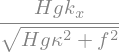

In [1]:
from sympy import symbols, init_printing, diff, sqrt
init_printing(use_unicode=True)
g, H, kappa, omega = symbols('g, H, kappa, omega', positive=True)
f, k_x, k_y = symbols('f, k_x, k_y', real=True)
diff(sqrt(f**2 + g*H*(k_x**2 + k_y**2)), k_x).subs(k_y, sqrt(kappa**2 - k_x**2))

The **wavevectors** are solutions of (see Sympy cell below)

$$\frac{d\boldsymbol k}{dt} = -\boldsymbol{\nabla}\omega_{abs} = -\frac{\partial \omega_{int}}{\partial H}\boldsymbol{\nabla}H -(\boldsymbol{\nabla U})\cdot\boldsymbol k = -\frac{g \kappa^2}{2\omega_{int}}\boldsymbol{\nabla}H - k_i\boldsymbol{\nabla}U_i.$$

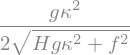

In [2]:
diff(sqrt(f**2 + g*H*kappa**2), H)

### Tracking the amplitude

*See Bühler (2014, §4.4.4) for this specific topic.*

The equations above form the ray tracing equations in the single-layer shallow-water equations.
To track the wave amplitude, one needs to use conservation of wave action density $\mathcal A = \bar E/\omega_{int}$, where "$\bar E$ is the phase-averaged density of disturbance energy", i.e., $\bar E \propto A_w^2$, where $A_w$ is the wave perturbation amplitude we are looking for. 

The conservation of wave action density reads
$$\frac{d\mathcal A}{dt} = - \mathcal A \boldsymbol{\nabla\cdot} (\boldsymbol c_{g}+\boldsymbol U) \quad\Leftrightarrow\quad \frac{d(\ln\mathcal A)}{dt} = - \boldsymbol{\nabla\cdot} (\boldsymbol c_g + \boldsymbol U).$$
*Careful: $\boldsymbol c_g$ in Bühler refers to the *local*, i.e., absolute, group velocity. For us, this symbol represents the intrinsic group velocity, which is why we need to add $\boldsymbol U$.*

Bühler then says that there are two methods to get the energy, then the amplitude, from this conservation law:
* Integrating over a volume, small enough for $\omega_{int}$ to be constant across it, and that travels with the *absolute* group velocity, yields a volume-integrated energy $\mathcal E$ that does not vary along the path. It's sort of like the continuity equation integrated over a volume, namely,
$$\frac{d\rho}{dt} = -\rho\boldsymbol{\nabla\cdot v}\quad \Rightarrow\quad \frac{d(\ln m)}{dt} = -\iiint\boldsymbol{\nabla\cdot v}\,dV = -\oint\!\!\!\!\!\!\int \boldsymbol{v\cdot}\,d\mathbf A$$
with $m = \iiint\rho\,dV$. If the volume boundaries follow the current $\boldsymbol v$, then the mass $m$ inside the volume doesn't change. Practically, this method requires to compute bundles of rays that are very close to one another, use $\mathcal E = constant$ along the path, and divide by the volume enclosed by the ray tips at each instant.
* Compute $\boldsymbol{\nabla\cdot} \boldsymbol c_g$ analytically (cf. SymPy cell below) and track the evolution along one ray. Here, Bühler says that this info needs to be integrated in the equations for the position and the wavevector, but I don't understand how, and it seems to add a lot of equations.

My take is to simply add the equation for $\ln\mathcal A$ as a 5th equation in the ODE system, but this one is more like a "passive tracer" equation since it won't feedback into the evolutions of $\boldsymbol r$ and $\boldsymbol k$. Sounds a lot more simple and economical than what Bühler suggests, unless I'm mistaken.

Unpacking that group velocity divergence,
$$ \boldsymbol{\nabla\cdot}\boldsymbol c_g = g\boldsymbol{\nabla\cdot}\left(\frac{H}{\omega_{int}}\boldsymbol k\right) = g \frac{\partial}{\partial H}\left(\frac{H}{\omega_{int}}\right)\left(\frac{\partial H}{\partial x}k_x + \frac{\partial H}{\partial y}k_y\right).$$

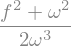

In [3]:
diff(H/sqrt(f**2 + g*H*kappa**2), H).subs(H*g*kappa**2, omega**2-f**2).factor()

The final equation for $\mathcal A$ is
$$\frac{d\ln(\mathcal A)}{dt} = -g\frac{\omega_{int}^2 + f^2}{2\omega_{int}^3}\left(\frac{\partial H}{\partial x}k_x + \frac{\partial H}{\partial y}k_y\right) - \frac{\partial U}{\partial x}- \frac{\partial V}{\partial y}.$$

To **sum up**,
$$\boxed{
\begin{align*}
    \frac{dx}{dt} & = \frac{g Hk_x}{\omega_{int}} + U, \\
    \frac{dy}{dt} & = \frac{g Hk_y}{\omega_{int}} + V, \\
    \frac{dk_x}{dt} & = -\frac{g k^2}{2\omega_{int}}\frac{\partial H}{\partial x} - k_x\frac{\partial U}{\partial x} - k_y\frac{\partial V}{\partial x},\\
    \frac{dk_y}{dt} & = -\frac{g k^2}{2\omega_{int}}\frac{\partial H}{\partial y} - k_x\frac{\partial U}{\partial y} - k_y\frac{\partial V}{\partial y},\\
     \text{and the passive}\quad\frac{d\ln(\mathcal A)}{dt}&  = -g\frac{\omega_{int}^2 + f^2}{2\omega_{int}^3}\left(\frac{\partial H}{\partial x}k_x + \frac{\partial H}{\partial y}k_y\right) - \frac{\partial U}{\partial x}- \frac{\partial V}{\partial y}.
\end{align*}
}$$

We solve this as a set of coupled ODEs with one of the `scipy.integrate` [routines](https://docs.scipy.org/doc/scipy/reference/integrate.html#solving-initial-value-problems-for-ode-systems).
I will use the default setting of `scipy.integrate.solve_ivp` ([man page](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp)), i.e., a Runge-Kutta 5(4) algorithm.

## The code

In [4]:
""" Foreplay """
import numpy as np
from scipy.fft import rfft, irfft, rfftfreq
from scipy.constants import pi
from scipy.interpolate import RegularGridInterpolator as RGI
import h5py
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [5]:
def deriv(field, dx, axis=0):
    """ The fields are periodic. We can compute their spatial derivatives with
    FFTs. We use rffts because the initial inputs are real.
    INPUT:
        field: the (2D) field we want to derive
        dx: the grid spacing
        axis: 0 for X, 1 for Y. """

    # nx = field.shape[axis]
    kx = rfftfreq(field.shape[axis], dx)

    Kx = np.tile(kx, (field.shape[axis-1], 1))
    if axis == 0:
        # If I ever use it for more than 2D, will need to add cases
        Kx = Kx.T

    return irfft(2*pi*Kx*1j*rfft(field, axis=axis), axis=axis)

In [6]:
def create_interpolants(file_id, variable, dx, IntMeth='linear'):
    """ Create interpolating functions for gridded data and its x and y
    derivatives. To be done once and only once
    'variable' is 'u', 'v' or 'h' """
    gridded = file_id['tasks'][variable][0, :, :]  # load 1st iteration only

    nx = gridded.shape[0]
    grid = np.arange(-nx/2*dx, nx/2*dx, dx)

    dgdx = deriv(gridded, dx, 0)
    dgdy = deriv(gridded, dx, 1)

    Gi = RGI((grid, grid), gridded, method=IntMeth)
    dGidx = RGI((grid, grid), dgdx, method=IntMeth)
    dGidy = RGI((grid, grid), dgdy, method=IntMeth)

    return Gi, dGidx, dGidy

In [7]:
def wint(x, y, kap2, f2, grav):
    """ Intrinsic frequency. 
    x, y and kap2 must have the same number of elements
    kap2 must be a 1D np.ndarray """
    if type(x) in [float, int, np.float64, np.float32]:
        H = Height([x, y])[0]
    else:
        if type(x) == list:  # If it's another type, I'm done
            x = np.array(x)
            y = np.array(y)
        H = Height([[x[ii], y[ii]] for ii in range(len(x))])
        
    return (f2 + grav*H*kap2)**.2

In [23]:
def rhs(t, r, grav, f2):
    """ The main attraction. Relies on the interpolants to be 
    passed as part of the outer scope, which isn't great.
    Create the interpolants directly here? could take forever.
    r: [x, y, kx, ky, lnA], with lnA the wave action log """
    
    if abs(r[0])<4.1*Lv and abs(r[1])<4.1*Lv:
        # We have not reached the end of the domain, we keep going
        k2 = r[2]**2 + r[3]**2
        
        U = Uvel([r[0], r[1]])[0]  # That's not anoying at all
        V = Vvel([r[0], r[1]])[0]
        H = Height([r[0], r[1]])[0]   # + Height([-4*Lv, -4*Lv])[0]
        dUdx = dUx([r[0], r[1]])[0]
        dVdx = dVx([r[0], r[1]])[0]
        dHdx = dHx([r[0], r[1]])[0]
        dUdy = dUy([r[0], r[1]])[0]
        dVdy = dVy([r[0], r[1]])[0]
        dHdy = dHy([r[0], r[1]])[0]
    
        oint = wint(r[0], r[1], k2, f2, grav)
        
        RHSs = [U + grav*H*r[2]/oint,
                V + grav*H*r[3]/oint, 
                -.5*grav*k2*dHdx/oint - r[2]*dUdx - r[3]*dVdx,
                -.5*grav*k2*dHdy/oint - r[2]*dUdy - r[3]*dVdy,
                -.5*grav*(oint**2 + f2)/(oint**3)*(dHdx*r[2] + dHdy*r[3]) - dUdx - dVdy]
        
    else:
        # We have reached far enough, no need to go any further
        RHSs = 5*[0.]
    
    return RHSs

### The mean flow: Jeff's data

I will use the data file Jeff gave me last December. The idea is to load the data ($U$, $V$, $W$), compute their spatial derivatives with FFTs, and finally, to create interpolating functions for all nine fields.

In [26]:
# Ray parameters
Lv = 25e3  # [m] vortex scale (fixed by Jeff)
bigK = 1.  # Kap = L/lambda_x = L*kx/(2*pi)
x0 = -4*Lv
yMax = 4*Lv
nrays = 41
dt = 312.2529  # [s] The simulation time step but can be anything small
file_name = 'Jeffrey_Uncu_Ro0.04Bu1.0Lr4.0_cyclonic.h5'

In [27]:
# Fixed and calculated quantities
dx = 500.  # [m]
fcor = 1e-4  # rad/s
grav = 9.81  # m/s2
Hm = 0.6371  # bacxkground depth

y0s = np.linspace(-yMax, yMax, nrays)
kx0 = 2*pi*bigK/Lv
c02ref = grav*Hm
f2 = fcor**2

oabs = (f2 + grav*Hm*kx0**2)**.2  # absolute frequency
cgabs = c02ref*kx0/oabs  # group speed w/o vortex
Ttransit = 2*abs(x0)/cgabs  # time it takes to go through domain if no vortex
t_array = np.arange(0., Ttransit, dt)

In [29]:
with h5py.File(file_name, mode='r') as fid:
    Uvel, dUx, dUy = create_interpolants(fid, 'u', dx)
    Vvel, dVx, dVy = create_interpolants(fid, 'v', dx)
    Height, dHx, dHy = create_interpolants(fid, 'h', dx)
    
Height([0., 0.])

array([0.61162382])

I will artificially decrease the speed of the algorithm by using the `t_eval=t_array` option. Two advantages:
1. All rays will have the same number of points, meaning I can put everyone in a big numpy array.
2. I can do a "global" scatterplot to have the same color scale across all rays.

In [30]:
nt = len(t_array)
rays = np.empty((5, nrays, nt))
Aws = np.empty((nrays, nt))
for nray, y0 in enumerate(y0s):
    r0 = [x0, y0, kx0, 0., 1.]
    ray = solve_ivp(lambda t, y: rhs(t, y, grav, f2), y0=r0, 
                    t_span=[0., Ttransit], t_eval=t_array)
    rays[:, nray, :] = ray.y
    
    k2s = ray.y[2]**2 + ray.y[3]**2
    oints = wint(ray.y[0], ray.y[1], k2s, f2, grav)
    Aws[nray, :] = (np.exp(rays[4, nray, :])*oints)**.5  # Wave amplitude
Aws /= Aws[0, 0]  # normalize by initial amplitude (same for all rays)

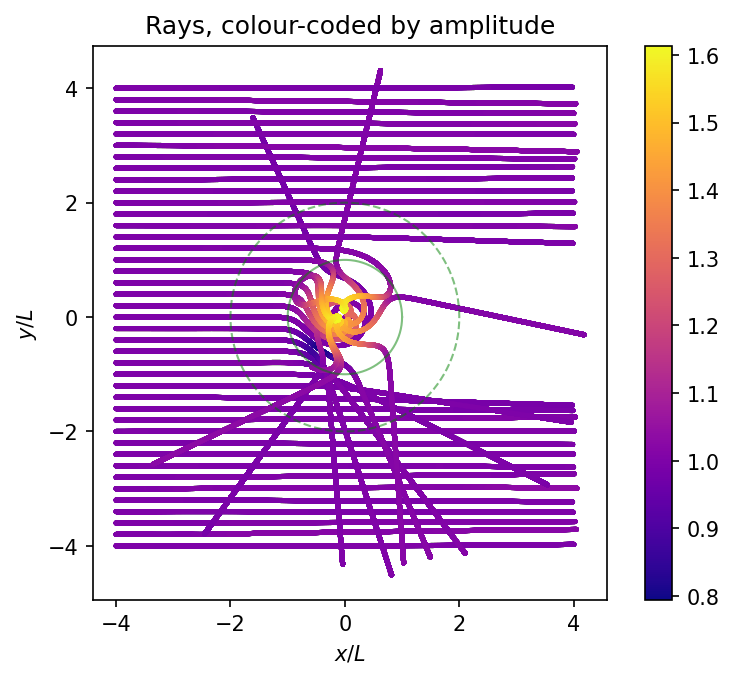

In [33]:
angles = np.linspace(0, 2*pi, 361)
xin, yin = Lv*np.cos(angles), Lv*np.sin(angles)
xout, yout = 2*Lv*np.cos(angles), 2*Lv*np.sin(angles)

fg, ax = plt.subplots(1, 1, dpi=150)
ax.plot(xin/Lv, yin/Lv, 'g', linewidth=1, alpha=0.5)
ax.plot(xout/Lv, yout/Lv, 'g--', linewidth=1, alpha=0.5)
cb = plt.scatter(rays[0, :, :]/Lv, rays[1, :, :]/Lv, s=2, c=Aws, cmap='plasma', alpha=1.)
ax.set_xlabel('$x/L$')
ax.set_ylabel('$y/L$')
ax.set_title("Rays, colour-coded by amplitude")
ax.set_aspect('equal')
plt.colorbar(ax=ax, orientation='vertical')